In [1]:

from google.colab import files
uploaded = files.upload()


Saving telco churn.csv.zip to telco churn.csv.zip


In [4]:
import pandas as pd

# Load the uploaded file
df = pd.read_csv("telco churn.csv.zip")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Convert TotalCharges to numeric (some are empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check the cleaned dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable first
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode other object (categorical) columns
cat_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Check result
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[903 130]
 [183 191]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:36:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


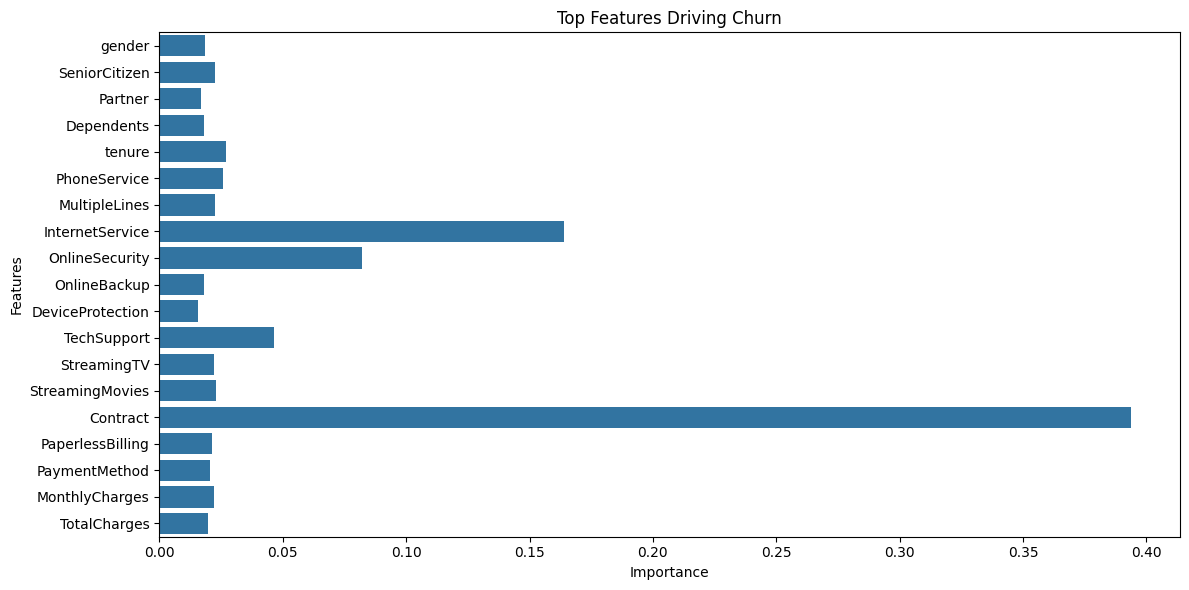

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=features)
plt.title("Top Features Driving Churn")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
